# Keras utility methods for streamlining training of convolutional neural net
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.


---

### What is this Notebook about?

In this notebook, we create a convolutional neural net (CNN) classifier to classify multiple (5) classes of flowers. But we don't dwell much on the architecture of the CNN or the optimizer. Instead, **we focus on how to use couple of utility methods from the Keras (TensorFlow) API to streamline the training of such models** (specifically for a classification task) with a proper data pre-processing, as long as they can be organized properly inside a single directory.

Basically, we want to,

> grab some data

> put them in a folder

> train a model

![grab-data-cnn](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/grab-data-cnn.png)

The dataset can be downloaded from the Kaggle website here,

https://www.kaggle.com/alxmamaev/flowers-recognition. 

As per the description below, the pictures are **not of same size**. However, they come **organized neatly in five directories named with the corresponding class labels**. We can take advantage of this organization and apply the Keras methods to streamline the training of our conv net.

Concretely, we will use the following utility classes/methods,

- `ImageDataGenerator` class
- `flow_from_directory` method of the `ImageDataGenerator` class
- `fit_generator` method (instead of plain vanila `fit` method) of Keras models

### Dataset
The dataset can be downloaded from the Kaggle website here,

https://www.kaggle.com/alxmamaev/flowers-recognition

The data collection is based on the data flicr, google images, yandex images. 
The pictures are divided into five classes,

- daisy, 
- tulip, 
- rose, 
- sunflower, 
- dandelion. 

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions.

### GPU

It is recommended to run this script on a GPU (with `TensorFlow-GPU`), as we will build a conv net with five convolutional layers and consequently, the training process with thousands of images can be computationally intensive.

For the Flowers dataset, a single epoch took ~ 1 minute on my modest laptop with NVidia GTX 1060 Ti GPU (6 GB Video RAM), Core i-7 8770 CPU, 16 GB DDR4 RAM.

Alternatively, you can take advantage of Google Colab, but loading and pre-processing the datasets can be a bit of hassle there.

---

## Data pre-processing

Note that the first part of this section is not essential for the training of the neural net. This set of code is just for illustration purpose and showing a few training images as an example.

Note the file path strings carefully. The orientation of the `\` depends on the OS - Windows or Linux. In a few places, we have to use double `\\` to avoid the control characters such as `\f`, `r`, and `\t` inside a plain string.

On my laptop, the data is stored in a folder one level above my Notebooks folder. Here is the organization,

![data-flower](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/data-flower-directory.PNG)

### Create directory variables. Count, and show images

In [1]:
import os

In [2]:
# Directory with daisy pictures
daisy_dir = os.path.join('..\Data\\flowers-recognition\daisy')

# Directory with dandelion pictures
dandelion_dir = os.path.join('..\Data\\flowers-recognition\dandelion')

# Directory with rose pictures
rose_dir = os.path.join('..\Data\\flowers-recognition\\rose')

# Directory with sunflower pictures
sunflower_dir = os.path.join('..\Data\\flowers-recognition\sunflower')

# Directory with tulip pictures
tulip_dir = os.path.join('..\Data\\flowers-recognition\\tulip')

In [3]:
train_daisy_names = os.listdir(daisy_dir)
print(train_daisy_names[:5])

train_rose_names = os.listdir(rose_dir)
print(train_rose_names[:5])

['100080576_f52e8ee070_n.jpg', '10140303196_b88d3d6cec.jpg', '10172379554_b296050f82_n.jpg', '10172567486_2748826a8b.jpg', '10172636503_21bededa75_n.jpg']
['10090824183_d02c613f10_m.jpg', '102501987_3cdb8e5394_n.jpg', '10503217854_e66a804309.jpg', '10894627425_ec76bbc757_n.jpg', '110472418_87b6a3aa98_m.jpg']


In [4]:
print('total daisy images:', len(os.listdir(daisy_dir)))
print('total dandelion images:', len(os.listdir(dandelion_dir)))
print('total rose images:', len(os.listdir(rose_dir)))
print('total sunflower images:', len(os.listdir(sunflower_dir)))
print('total tulip images:', len(os.listdir(tulip_dir)))

total daisy images: 769
total dandelion images: 1055
total rose images: 784
total sunflower images: 734
total tulip images: 984


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Showing some daisy pictures...



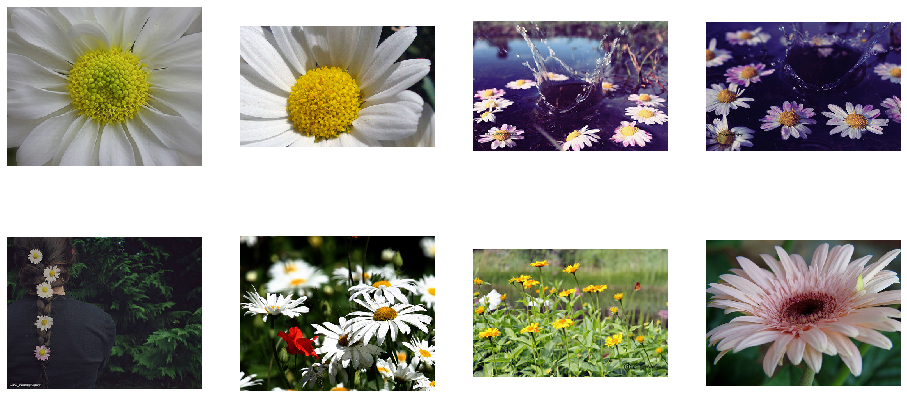

Showing some rose pictures...



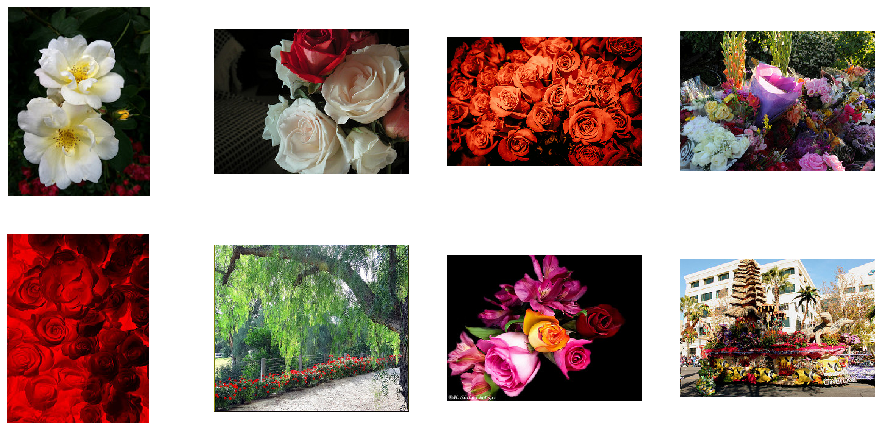

In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_daisy_pix = [os.path.join(daisy_dir, fname) 
                for fname in train_daisy_names[pic_index-8:pic_index]]
next_rose_pix = [os.path.join(rose_dir, fname) 
                for fname in train_rose_names[pic_index-8:pic_index]]

print ("Showing some daisy pictures...")
print()
for i, img_path in enumerate(next_daisy_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

print ("Showing some rose pictures...")
print()
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i, img_path in enumerate(next_rose_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Building the `ImageDataGenerator` object

This is where the actual magic happens.

The official decription of the `ImageDataGenerator` class says "*Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).*"

Basically, it can be used **to augment image data with a lot of built-in pre-processing such as scaling, shifting, rotation, noise, whitening, etc**. Right now, we just use the `rescale` attribute to scale the image tensor values between 0 and 1.

For more details and actual implementation, **[see this official documentation page.](https://keras.io/preprocessing/image/)**

But the real utility of this class for the current demonstration is the super useful method `flow_from_directory` which can pull image files one after another from the specified directory.

Note that, **this directory just has to be the top-level directory where all the sub-directories of individual classes can be stored separately**. The flow_from_directory method automatically scans through all the sub-directories and sources the images along with their appropriate labels.

We can specify the class names (as we did here with the `classes` argument) but this is optional. However, we will later see, how this can be useful for selective training from a large trove of data.

Another useful argument is the `target_size`, which lets us resize the source images to a uniform size of 200 x 200, no matter the original size of the image. That is some cool image-processing right there with a simple function argument.

We also specify the batch size. If you leave `batch_size` unspecified, by default, it will be set to 32.

When you run this code, the Keras function scans through the top-level directory, finds all the image files, and automatically labels them with the proper class (based on the sub-directory they were in).

![imagedatagen](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/keras-imagedatagen.png)

Isn't that cool?

But wait, there is more. This is a Python generator object and that means it will be used to 'yield' the data one by one during the training. This significantly reduces the problem of dealing with a very large dataset, whose contents cannot be fitted into memory at one go. [Look at this article to understand it better](https://towardsdatascience.com/pythons-list-generators-what-when-how-and-why-2a560abd3879).

In [7]:
batch_size = 128

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '../Data//flowers-recognition',  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200 x 200
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['daisy','dandelion','rose','sunflower','tulip'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Found 4323 images belonging to 5 classes.


---

## Building the model

In [9]:
import tensorflow as tf

### Model architecture

In [18]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(5, activation='softmax')
])

### Model summary

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)        36928     
__________

### Optimizer

In [20]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Total number of samples found
We will see shortly where this quantity is used in training.

In [21]:
total_sample=train_generator.n

---

## Training

### Fit using the `fit_generator` method which utilizes the `train_generator` object

Recalle the definition of the `train_generator` object.

```
train_generator = train_datagen.flow_from_directory(
        '../Data//flowers-recognition',  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200 x 200
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['daisy','dandelion','rose','sunflower','tulip'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')
```

We discussed before what cool things this does with the `flow_from_directory` method and with its arguments.

Note the `steps_per_epoch` argument to `fit_generator`. Since, this is a generic [Python generator](https://realpython.com/introduction-to-python-generators/), it never stops and therefore will not know where a particular epoch is ending and the next one is starting. **We have to let it know the steps in a single epoch**. This is, in most cases, the length of the total training sample divided by the batch size.

In the previous section, we found out the total sample size as `total_sample`. Therefore, in this particular case, the `steps_per_epoch` is set to `int(total_sample/batch_size)` which is `34`. Therefore, you will see 34 steps per epoch in the training log below.

In [22]:
n_epochs = 30

In [23]:
history = model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=n_epochs,
        verbose=1)

Epoch 1/30
34/34 [==============================] - 6s 174ms/step - loss: 1.5105 - acc: 0.3308
Epoch 2/30
34/34 [==============================] - 6s 186ms/step - loss: 1.2333 - acc: 0.4696
Epoch 3/30
34/34 [==============================] - 7s 195ms/step - loss: 1.1395 - acc: 0.5304
Epoch 4/30
34/34 [==============================] - 7s 192ms/step - loss: 1.0404 - acc: 0.5806
Epoch 5/30
34/34 [==============================] - 7s 197ms/step - loss: 0.9892 - acc: 0.6107
Epoch 6/30
34/34 [==============================] - 7s 203ms/step - loss: 0.9206 - acc: 0.6461 2s - loss: 0.9348 - 
Epoch 7/30
34/34 [==============================] - 7s 217ms/step - loss: 0.8905 - acc: 0.6549
Epoch 8/30
34/34 [==============================] - 7s 198ms/step - loss: 0.8680 - acc: 0.6697
Epoch 9/30
34/34 [==============================] - 8s 248ms/step - loss: 0.8220 - acc: 0.6891
Epoch 10/30
34/34 [==============================] - 6s 187ms/step - loss: 0.7906 - acc: 0.6972
Epoch 11/30
34/34 [=========

### Plot the accuracy/loss over the progression of training (epochs)

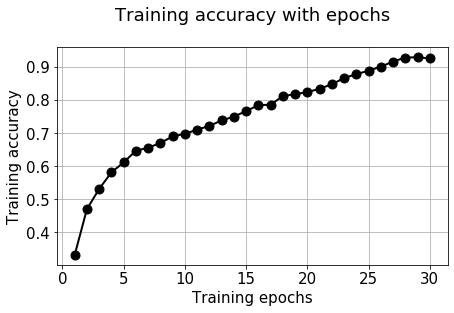

In [25]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['acc'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

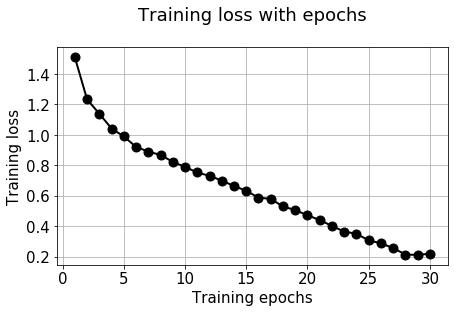

In [26]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['loss'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training loss with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

---

## Encapsulate all of these in a single function?

OK. What have we accomlished so far?

We have been able to utilize Keras `ImageDataGenerator` class and `fit_generator` method to pull images automatically from a single directory, label them, resize and scale them, and flow them one by one (in batches) for training a neural network.

Can we encapsulate all of these in a single function?

One of the central goals of making useful software/computing systems is **abstraction i.e. hide the gory details of internal computation and data manipulation and present a simple and intuitive working interface/ API to the user**. Just as a practice towards that goal, we can try to encapculate the process we followed above, in a single function.

Here is the idea,

![keras-datagen](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/keras-imagedatagen-function-1.png)

### Aim for a flexible API with useful arguments

When you are designing a high-level API, **why not go for more generalization than what is required for this particular demo with flowers dataset**? With that on our mind, we can think of providing additional arguments to this function for making it applicable to other image classification cases (we will see an example soon).

Specifically, we provide the following arguments in the function,

- `train_directory`: The directory where the training images are stored in separate folders. These folders should be named as per the classes.
- `target_size`: Target size for the training images. A tuple e.g. (200,200)
- `classes`: A Python list with the classes, for which we want the training to happen. This forces the generator choose specific files from the `train_directory` and not look at all the data.
- `batch_size`: Batch size for training
- `num_epochs`: Number of epochs for training
- `num_classes`: Number of output classes to consider
- `verbose`: Verbosity level of the training, passed on to the `fit_generator` method

Of course, we could have provided additional arguments corresponding to the whole model architecture or optimizer settings. This demo is not focused on such issues, and therefore, we keep it compact.

In [27]:
def train_CNN(train_directory,target_size=(200,200), classes=None,
              batch_size=128,num_epochs=20,num_classes=5,verbose=0):
    """
    Trains a conv net for the flowers dataset with a 5-class classifiction output
    Also provides suitable arguments for extending it to other similar apps
    
    Arguments:
            train_directory: The directory where the training images are stored in separate folders.
                            These folders should be named as per the classes.
            target_size: Target size for the training images. A tuple e.g. (200,200)
            classes: A Python list with the classes 
            batch_size: Batch size for training
            num_epochs: Number of epochs for training
            num_classes: Number of output classes to consider
            verbose: Verbosity level of the training, passed on to the `fit_generator` method
    Returns:
            A trained conv net model
    
    """
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import tensorflow as tf
    from tensorflow.keras.optimizers import RMSprop
    
    # ImageDataGenerator object instance with scaling
    train_datagen = ImageDataGenerator(rescale=1/255)

    # Flow training images in batches using the generator
    train_generator = train_datagen.flow_from_directory(
            train_directory,  # This is the source directory for training images
            target_size=target_size,  # All images will be resized to 200 x 200
            batch_size=batch_size,
            # Specify the classes explicitly
            classes = classes,
            # Since we use categorical_crossentropy loss, we need categorical labels
            class_mode='categorical')
    
    input_shape = tuple(list(target_size)+[3])
    
    # Model architecture
    model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 512 neuron in the fully-connected layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Optimizer and compilation
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
    
    # Total sample count
    total_sample=train_generator.n
    
    # Training
    model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=num_epochs,
        verbose=verbose)
    
    return model

### Test

Now we test our `train_CNN` function by simply supplying a folder/directory name and getting back a trained model which can be used for predictions!

Let's also suppose that we want to train only for 'daisy', 'rose', and 'tulip' now and ignore the other two flowers' data. We simply pass on a list to the `classes` argument. In this case, don't forget to set the `num_classes` argument to 3. You will notice how the steps per epoch is automatically reduces to 20 as the number of training samples is less than the case above.

Also, note that the `verbose` is set to 0 by default in the function above, and therefore you need to specify explicitly `verbose=1` if you want to monitor the progress of the training epoch-wise!

Basically, we are able to get a fully trained CNN model with 2 lines of code now!

In [28]:
train_directory = "../Data//flowers-recognition/"

In [29]:
trained_model=train_CNN(train_directory=train_directory,classes=['daisy','rose','tulip'],
                        num_epochs=30,num_classes=3,verbose=1)

Found 2537 images belonging to 3 classes.
Epoch 1/30
20/20 [==============================] - 4s 185ms/step - loss: 1.1097 - acc: 0.4072
Epoch 2/30
20/20 [==============================] - 4s 181ms/step - loss: 0.9958 - acc: 0.4919
Epoch 3/30
20/20 [==============================] - 4s 193ms/step - loss: 0.9761 - acc: 0.5613
Epoch 4/30
20/20 [==============================] - 4s 189ms/step - loss: 0.8854 - acc: 0.5806
Epoch 5/30
20/20 [==============================] - 4s 195ms/step - loss: 0.8330 - acc: 0.6074 2s - loss: 0.8538 
Epoch 6/30
20/20 [==============================] - 4s 209ms/step - loss: 0.8416 - acc: 0.6212
Epoch 7/30
20/20 [==============================] - 4s 204ms/step - loss: 0.7536 - acc: 0.6602
Epoch 8/30
20/20 [==============================] - 4s 198ms/step - loss: 0.7583 - acc: 0.6496 0s - loss: 0.7625 - acc: 0.
Epoch 9/30
20/20 [==============================] - 4s 209ms/step - loss: 0.7067 - acc: 0.6886 3s - loss: 0.7
Epoch 10/30
20/20 [======================

## Let's see how this function can be useful for another dataset

A rich yet manageable image classification dataset is Caltech-101. By manageable I meant, not as large as the ImageNet database, which requires massive hardware infrastructure to train, and therefore, out of bounds, for testing cool ideas quickly on your laptop, yet diverse enough for practicing and learning the tricks and trades of convolutional neural networks.

![caltech-101](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Caltech-101-header.PNG)

We download the famous **Caltech-101 dataset** from http://www.vision.caltech.edu/Image_Datasets/Caltech101/. This dataset was somewhat a **precursor to the [ImageNet database](http://image-net.org)**, which is the current gold standard for image classification data repository.

Caltech-101 is an image datasets of diverse types of objects belonging to 101 categories. There are about 40 to 800 images per category. Most categories have about 50 images.  The size of each image is roughly 300 x 200 pixels.

The dataset was built by none other than Prof. Fei Fei Li and her colleagues (Marco Andreetto, and Marc 'Aurelio Ranzato) at Caltech in 2003 when she was a graduate student there. We can surmise, therefore, that Caltech-101 was a direct precursor for her work on the ImageNet.

We download the dataset and uncompress the contents in the same Data folder as before. The directory looks like following,

![caltech-101-folder](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Caltech-101-folder.PNG)

Now, all we have to do is to pass on the address of this directory to the function and choose what categories of image we want to train the model for. Let's say we want to train the model for classification between ***'cup'*** and ***'crab'***. We can just pass their names as a list to the `classes` argument as before. 

Also note that, we may have to reduce the `batch_size` significantly for this dataset as the total number of training images will be much lower compared to the Flowers dataset and if the `batch_size` is higher than the total sample then we will have `steps_per_epoch` equal to 0 and that will create an error during training.

In [30]:
train_directory = "../Data/101_ObjectCategories/"

In [31]:
model_caltech101 = train_CNN(train_directory=train_directory,classes=['crab','cup'],batch_size=4,num_epochs=25,num_classes=2,verbose=1)

Found 130 images belonging to 2 classes.
Epoch 1/25
33/33 [==============================] - 1s 29ms/step - loss: 0.7793 - acc: 0.5308
Epoch 2/25
33/33 [==============================] - 0s 10ms/step - loss: 0.6971 - acc: 0.5154
Epoch 3/25
33/33 [==============================] - 0s 9ms/step - loss: 0.6988 - acc: 0.5615
Epoch 4/25
33/33 [==============================] - 0s 9ms/step - loss: 0.6989 - acc: 0.5538
Epoch 5/25
33/33 [==============================] - 0s 9ms/step - loss: 1.0165 - acc: 0.6385
Epoch 6/25
33/33 [==============================] - 0s 10ms/step - loss: 0.6283 - acc: 0.7000
Epoch 7/25
33/33 [==============================] - 0s 9ms/step - loss: 0.6152 - acc: 0.6923
Epoch 8/25
33/33 [==============================] - 0s 9ms/step - loss: 0.5262 - acc: 0.7692
Epoch 9/25
33/33 [==============================] - 0s 9ms/step - loss: 0.4061 - acc: 0.8385
Epoch 10/25
33/33 [==============================] - 0s 9ms/step - loss: 0.3649 - acc: 0.8154A: 0s - loss: 0.3487 - acc

### Download random crab and cup pictures from the internet and test the model with them

So, we saw how easy it was to just pass on the training images' directory address to the function and train a conv net with our chosen classes. **Is the model any good**? Let's find out by testing it with random pictures downloaded from the internet.

Remember, the Caltech-101 dataset was created by Fei Fei Li and colleagues back in 2003. So, there is little chance that any of the newer images on the internet will be in the dataset.

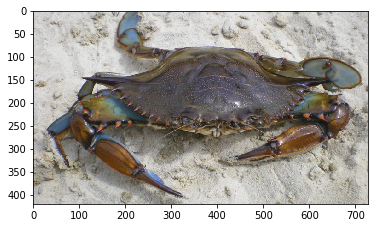

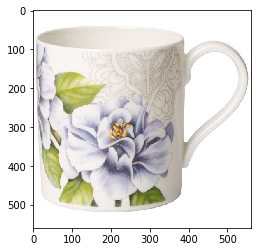

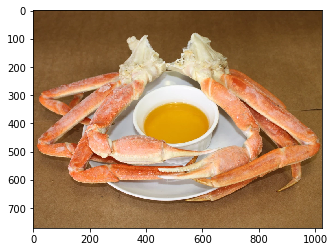

In [32]:
img_path = '../Data/101_ObjectCategories/Test_images/crab-1.jpg'
img_crab = mpimg.imread(img_path)
plt.imshow(img_crab)
plt.show()

img_path = '../Data/101_ObjectCategories/Test_images/cup-1.jpg'
img_cup = mpimg.imread(img_path)
plt.imshow(img_cup)
plt.show()

img_path = '../Data/101_ObjectCategories/Test_images/crab-cup-1.jpg'
img_crab_cup = mpimg.imread(img_path)
plt.imshow(img_crab_cup)
plt.show()

In [33]:
from PIL import Image

In [34]:
img_crab=Image.open('../Data/101_ObjectCategories/Test_images/crab-1.jpg')
img_cup=Image.open('../Data/101_ObjectCategories/Test_images/cup-1.jpg')
img_crab_cup=Image.open('../Data/101_ObjectCategories/Test_images/crab-cup-1.jpg')

In [35]:
img_crab = img_crab.resize((200,200))
img_cup = img_cup.resize((200,200))
img_crab_cup = img_crab_cup.resize((200,200))

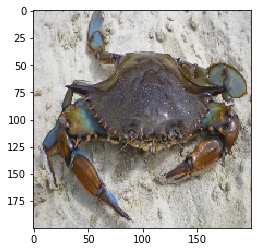

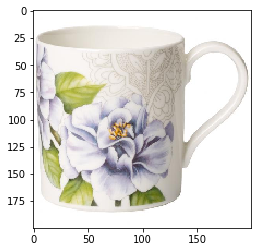

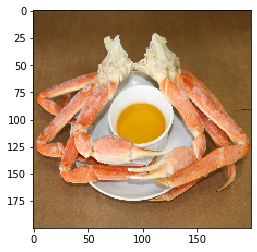

In [36]:
plt.imshow(img_crab)
plt.show()

plt.imshow(img_cup)
plt.show()

plt.imshow(img_crab_cup)
plt.show()

In [37]:
# Expand dimensions for proper prediction
import numpy as np
img_crab=np.expand_dims(img_crab,axis=0)
img_cup=np.expand_dims(img_cup,axis=0)
img_crab_cup=np.expand_dims(img_crab_cup,axis=0)

In [38]:
model_caltech101.predict(img_crab)

array([[1., 0.]], dtype=float32)

It predicts the image to be in class 1 which is crab.

In [39]:
model_caltech101.predict(img_cup)

array([[0., 1.]], dtype=float32)

It predits the image to be in class 2, which is cup.

In [40]:
model_caltech101.predict(img_crab_cup)

array([[0., 1.]], dtype=float32)

It predicts the image to be in class 2 i.e. cup. I guess that is almost fair for this image!